In [2]:
###################
# Outlier detection
###################
import os
from joblib import Parallel, delayed
import pandas as pd
import sqlite3
from statsmodels.api import OLS, add_constant
import ruptures as rpt
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from matplotlib.ticker import FuncFormatter
import numpy as np


In [3]:
##################################
# Python SQLite Conversion Reader
##################################
last_db_path = None
sql_columns = []

class FromSQLite:
    pathDB = os.path.join(os.getcwd(), "basedata", "total_base_data.db")
    
    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INTEGER"
        elif pd.api.types.is_float_dtype(dtype):
            return "REAL"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "DATETIME"
        else:
            return "TEXT"  # Default to TEXT for other types

    @staticmethod
    def getData(SQL_columns='*', importer=None, exporter=None, year=None, product_code=None, value=None, quantity=None, table_name="base_data", path=pathDB):
        """
        Fetch data from SQLite with optional filters.

        Args:
            SQL_columns (str): Columns to select. Default is '*'.
            importer (list, optional): List of import countries. Default is None.
            exporter (list, optional): List of export countries. Default is None.
            year (list, optional): List of years. Default is None.
            product_code (list, optional): List of product codes. Default is None.
            value (float, optional): Minimum value. Default is None.
            quantity (float, optional): Minimum quantity. Default is None.
            table_name (str, optional): Name of the table in the database. Default is "base_data".
            path (str, optional): Path to the database file. Default is pathDB.

        Returns:
            pd.DataFrame: Filtered data.
        """
        if not os.path.exists(path):
            print(f"ERROR: Database file '{path}' does not exist.")
            return None

        query = f"SELECT {SQL_columns} FROM {table_name} WHERE 1=1"
        params = []
        
        if exporter:
            print('Getting exporter', end="")
            placeholders = ', '.join('?' for _ in exporter)
            query += f" AND export_country IN ({placeholders})"
            params.extend(exporter)

        if importer:
            print('Getting importer', end="")
            placeholders = ', '.join('?' for _ in importer)
            query += f" AND import_country IN ({placeholders})"
            params.extend(importer)

        if year:
            print('Getting years', end="")
            placeholders = ', '.join('?' for _ in year)
            query += f" AND year IN ({placeholders})"
            params.extend(year)

        if product_code:
            print('Getting product codes', end="")
            placeholders = ', '.join('?' for _ in product_code)
            query += f" AND code IN ({placeholders})"
            params.extend(product_code)

        if value:
            print('Getting value', end="")
            placeholders = ', '.join('?' for _ in value)
            query += f" AND value IN ({placeholders})"
            params.append(value)

        if quantity:
            print('Getting quantity', end="")
            placeholders = ', '.join('?' for _ in quantity)
            query += f" AND quantity IN ({placeholders})"
            params.append(quantity)

        try:
            with sqlite3.connect(path) as conn:
                df = pd.read_sql_query(query, conn, params=params)
        except sqlite3.OperationalError as e:
            print(f"SQL Error: {e}")
            return None

        return df

    def pushData(df, table_name='base_data', db_path=pathDB):
        """
        Push data into SQLite database, adding only new rows and handling missing columns.

        Args:
            df (pd.DataFrame): Data to push into the database.
            table_name (str): Target table name.
            db_path (str): Path to the SQLite database file.
        """
        global last_db_path, sql_columns  # Declare global variables

        db_path = db_path or FromSQLite.pathDB

        # Ensure the directory for the database exists
        if not os.path.exists(os.path.dirname(db_path)):
            os.makedirs(os.path.dirname(db_path))

        try:
            # Connect to the SQLite database
            with sqlite3.connect(db_path) as conn:
                cursor = conn.cursor()

                # Check if the table exists
                cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}';")
                table_exists = cursor.fetchone() is not None

                if not table_exists:
                    # Create the table with the DataFrame's schema
                    print(f"Table '{table_name}' does not exist. Creating it...")
                    df.head(0).to_sql(table_name, conn, if_exists='replace', index=False)

                # Check if the database path is the same as the last call
                if db_path != last_db_path:
                    # Cache the SQL column names for the table
                    cursor.execute(f"PRAGMA table_info({table_name});")
                    sql_columns = [row[1] for row in cursor.fetchall()]  # Get column names
                    last_db_path = db_path

                # Check for missing columns
                df_columns = df.columns.tolist()
                print(df_columns)
                missing_in_sql = set(df_columns) - set(sql_columns)

                # Add missing columns to the table if any
                if missing_in_sql:
                    for column in missing_in_sql:
                        col_type = FromSQLite.infer_sql_type(df[column].dtype)
                        cursor.execute(f"ALTER TABLE {table_name} ADD COLUMN {column} {col_type};")
                    print(f"Added missing columns: {missing_in_sql}", end="")

                # Push data into the table
                # Use pandas' `to_sql` with `if_exists='append'` to handle insertion
                df.to_sql(table_name, conn, if_exists='append', index=False)

                print(f"Data successfully pushed to table '{table_name}'.", end="")

        except Exception as e:
            print(f"Error pushing data: {e}")

    @staticmethod
    def updateData(table_name, updates, conditions, db_path=None):
        """
        Update data in SQLite database based on conditions.
        """
        db_path = db_path or os.path.join(os.getcwd(), "basedata", "total_base_data.db")

        try:
            with sqlite3.connect(db_path) as conn:
                cursor = conn.cursor()
                update_clause = ', '.join(f"{k} = ?" for k in updates.keys())
                condition_clause = ' AND '.join(f"{k} = ?" for k in conditions.keys())
                query = f"UPDATE {table_name} SET {update_clause} WHERE {condition_clause}"
                params = list(updates.values()) + list(conditions.values())
                cursor.execute(query, params)
                conn.commit()
        except Exception as e:
            print(f"Error updating data: {e}")

    def summarize(db_path=pathDB):
        # Get database size
        db_size = os.path.getsize(db_path) / (1024 * 1024)
        if db_size > 1000: 
            db_size /= 1024
            print(f"Database size: {db_size:.2f} GB\n")
        else:
            print(f"Database size: {db_size:.2f} MB\n")

        # Connect to the database
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()

            # List all tables
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = [row[0] for row in cursor.fetchall()]
            print("Tables in the database:")
            print(tables, "\n")

            # Summarize each table
            for table in tables:
                print(f"Summary for table '{table}':")

                # Get schema
                cursor.execute(f"PRAGMA table_info({table});")
                schema = cursor.fetchall()
                print("Schema:")
                for column in schema:
                    print(f"  {column}")

                # Get row count
                cursor.execute(f"SELECT COUNT(*) FROM {table};")
                row_count = cursor.fetchone()[0]
                print(f"Row count: {row_count}")

                # Get sample data
                try:
                    # Random sample (5 rows)
                    random_sample = pd.read_sql_query(f"SELECT * FROM {table} ORDER BY RANDOM() LIMIT 5;", conn)
                    print("\nRandom Sample:")
                    print(random_sample)

                    # First 5 rows sorted by year
                    first_by_year = pd.read_sql_query(f"SELECT * FROM {table} ORDER BY year ASC LIMIT 5;", conn)
                    print("\nFirst 5 Rows by Year:")
                    print(first_by_year)

                    # Last 5 rows sorted by year
                    last_by_year = pd.read_sql_query(f"SELECT * FROM {table} ORDER BY year DESC LIMIT 5;", conn)
                    print("\nLast 5 Rows by Year:")
                    print(last_by_year)

                except Exception as e:
                    print(f"Error fetching sample data: {e}")

                print("\n")


In [4]:
def detect_anomalies(df, type):
    anomalies = []
    grouped = df.groupby(['export_country', 'import_country'])
    for (exporter, importer), group in grouped:
        if len(group) > 5:  # Minimum data threshold
            group = group.sort_values('year')
            X = add_constant(group['year'])
            y = group[type]
            model = OLS(y, X).fit()
            residuals = model.resid

            # Z-score for residuals
            z_scores = (residuals - residuals.mean()) / residuals.std()
            flagged = group.loc[z_scores.abs() > 3]
            if not flagged.empty:
                anomalies.append(flagged)
        else:
            print(f'ANOMALIES -- Not enough data for {exporter}-{importer}. Skipping.', end="\r")

    if anomalies:
        return pd.concat(anomalies, ignore_index=True)  # Combine all flagged anomalies
    else:
        print(f'ANOMALIES --- No anomalies detected', end="\r")
        return pd.DataFrame()  # Return empty DataFrame for consistency


In [5]:
def display_viz_array(viz_array):
    """
    Display all visualizations stored in the array.

    Parameters:
    - viz_array: Array of tuples (Figure, Axes).
    """
    n = len(viz_array)  # Number of visualizations
    fig, axes = plt.subplots(n, 2, figsize=(12, 6 * n))

    # Ensure axes are iterable for both single and multiple visualizations
    if n == 1:
        axes = [axes]

    # Loop through all stored visualizations and recreate the plots
    for i, data in enumerate(viz_array):
        time_series = data['time_series']
        components = data['pca_components']
        years = data['years']
        type_ = data['type']
        export_country = data['export_country']
        import_country = data['import_country']

        # Plot the original time series data
        axes[i][0].plot(time_series.T, alpha=0.7)
        axes[i][0].set_title(f'Original Time Series Data ({type_.capitalize()}): {export_country} - {import_country}')
        axes[i][0].set_xlabel('Time (Years)')
        axes[i][0].set_ylabel(f'{type_.capitalize()} Values')
        axes[i][0].grid()

        # Plot the principal components
        for j, component in enumerate(components[:3], 1):  # Plot up to 3 components
            axes[i][1].plot(years, component, label=f'Principal Component {j}')
        axes[i][1].set_title(f'Principal Components Through Time ({type_.capitalize()}): {export_country} - {import_country}')
        axes[i][1].set_xlabel('Time (Years)')
        axes[i][1].set_ylabel('Component Value')
        axes[i][1].legend()
        axes[i][1].grid()

    plt.tight_layout()
    plt.show()
    return



In [6]:
def data_treatment(data, type, norm='untreated', missing=''):
    data.reset_index
    if not data['trade_direction'].empty: # Bilateral
        # Iterative aggregation: First 4 digits, then 2 digits
        for direction in data['trade_direction'].unique():
            data_per_country = data[data['trade_direction'] == direction]
            for group_size in [4, 2]:
                missing_rows = data_per_country[data_per_country.isna().any(axis=1)].copy()
                if missing == 'aggregate' and not missing_rows.empty:
                    # Add a temporary column for grouping
                    missing_rows['code_group'] = missing_rows['code'].str[:group_size]
                    aggregated = missing_rows.groupby('code_group').sum(min_count=1).drop(columns='code')
                    aggregated.reset_index(drop=False, inplace=True)
                    aggregated = aggregated.rename(columns={'code_group':'code'})
                    aggregated['trade_direction'] = direction
                
                    data_per_country = data_per_country[~data_per_country['code'].isin(missing_rows['code'])]
    
                    shared_columns = list(set(data_per_country.columns) & set(aggregated.columns))
                    data_per_country = pd.merge(left=data_per_country, right=aggregated, how='outer', on=shared_columns)
                else: 
                    break
            if not data_per_country[data_per_country.isna().any(axis=1)].empty:
                data_per_country.dropna()

            data = data[data['trade_direction'] != direction]
            shared_columns = list(set(data.columns) & set(data_per_country.columns))
            data = pd.merge(left=data, right=data_per_country, how='outer', on=shared_columns).sort_values('trade_direction', axis=0).sort_values('code', axis=0)

        data.set_index(['code','trade_direction'], inplace=True, drop=True)
    else: # Not bilateral
        for group_size in [4, 2]:
            missing_rows = data[data.isna().any(axis=1)].copy()
            if missing == 'aggregate' and not missing_rows.empty:
                # Add a temporary column for grouping
                missing_rows['code_group'] = missing_rows['code'].str[:group_size]
                aggregated = missing_rows.groupby('code_group').sum(min_count=1).drop(columns='code')
                aggregated.reset_index(drop=False, inplace=True)
                aggregated = aggregated.rename(columns={'code_group':'code'}, inplace=True)

                data = data[~data['code'].isin(missing_rows['code'])]

                shared_columns = list(set(data.columns) & set(aggregated.columns))
                data = pd.merge(left=data, right=aggregated, how='outer', on=shared_columns)
            else: 
                break
        data.set_index(['code'], inplace=True, drop=True)
    if not data[data.isna().any(axis=1)].empty:
            data = data.dropna()


    if norm == 'change':
        #data = pd.concat([data[['code', 'trade_direction']], (data.drop(columns=['code', 'trade_direction'])).diff(axis=1)])
        data = data.dropna(axis=1, how='all')
    elif norm == 'changelog':
        data = np.log(data).diff(axis=1)    
        #data = pd.concat([data[['code', 'trade_direction']], np.log(data.drop(columns=['code', 'trade_direction'])).diff(axis=1)])

    data = data.dropna(axis=1, how='all')

    return data

def perform_pca(df, figs, type, pair):
    """
    Perform PCA on the given DataFrame and visualize the original data, PCA results, 
    and the principal components through time.

    Parameters:
    - df: DataFrame containing the data to perform PCA on.
    - type: The type of data (e.g., 'value', 'quantity', 'v/q').
    - pair: Tuple containing the export and import country.

    Returns:
    - reduced_data: PCA-transformed data.
    """
    # Extract export/import country
    export_country, import_country = pair

    # Ensure the input data is in the correct format (as a NumPy array)
    time_series = df.values
    years = df.columns  # Extract year labels from the DataFrame

    # Determine the optimal number of components using MLE (if enough samples are available)
    try:
        pca = PCA(n_components='mle', svd_solver='full')  # Use MLE for automatic dimensionality reduction
        reduced_data = pca.fit_transform(time_series)
    except ValueError as e:
        pca = PCA(n_components=min(2, time_series.shape[1]))
        reduced_data = pca.fit_transform(time_series)

    # Create figure and axes for visualization

    # Example: Append data to viz_array
    figs.append({
        'time_series': time_series,
        'pca_components': pca.components_,
        'type': type,
        'export_country': export_country,
        'import_country': import_country,
        'years': years
    })

    # Return reduced data and 2D array of Axes
    return reduced_data, figs

In [7]:
def product_outlier_detection(pair, pathDB, method, pbar=None, type='value'):
    if pbar:
        pbar.update(1)

    try:
        # Query to fetch data for the given product code
        query = f"""
            SELECT 
                year,
                code,
                quantity,
                value
            FROM base_data
            WHERE 
                export_country = '{pair[0]}' AND import_country = '{pair[1]}'
            ORDER BY 
                year;
        """
        with sqlite3.connect(pathDB) as conn:
            product_df = pd.read_sql_query(query, conn)

        # Preprocess data based on `type`
        if type == 'value':
            product_df = product_df[['code', 'value', 'year']].dropna(subset=['value'])
            product_df['value'] = pd.to_numeric(product_df['value'], errors='coerce')
        elif type == 'quantity':
            product_df = product_df[['code', 'quantity', 'year']].dropna(subset=['quantity'])
            product_df['quantity'] = pd.to_numeric(product_df['quantity'], errors='coerce')
        elif type == 'v/q':
            product_df = product_df.dropna(subset=['value', 'quantity', 'code'])
            product_df = product_df[product_df['quantity'] != 0]
            product_df['v/q'] = product_df['value'] / product_df['quantity']
            product_df = product_df[['code', 'v/q', 'year']]
            product_df['v/q'] = pd.to_numeric(product_df['v/q'], errors='coerce')

        # Apply data treatment
        product_df = product_df.pivot(index="code", columns="year", values=type).reset_index()
        product_df = data_treatment(product_df, type, norm='changelog', missing='aggregate')
        
        # normalization
        if 'z-score' in method:
            anomalies = detect_anomalies(product_df, type)
            if not anomalies.empty:
                anomalies['type'] = 'anomaly'  # Add a marker column for anomalies
                print(f"Anomalies found for product {code}.", end="\r")
        
        if 'Gaussian' in method:
            # Detect change points
            change_points = detect_change_points(product_df, type)
            if not change_points.empty:
                change_points['type'] = 'change_point'  # Add a marker column for change points
                print(f"Change points detected for product {code}.", end="\r")
        
        if 'PCA' in method: 
            pca_result = perform_pca(product_df, type, pair)

        # Merge anomalies and change points
        if not anomalies.empty and not change_points.empty:
            df = pd.concat([anomalies, change_points], ignore_index=True)
        elif not anomalies.empty:
            df = anomalies
        elif not change_points.empty:
            df = change_points
        else:
            df = pd.DataFrame()  # Empty DataFrame if no results

        return df
    except Exception as e:
        print(f"Error processing product: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

In [8]:
def product_outlier_detection_bilateral(pair, figs, pathDB, method, type='value'):

    try:
        # Query to fetch bilateral trade data
        query = f"""
            SELECT 
                year,
                code,
                quantity,
                value,
                export_country,
                import_country
            FROM base_data
            WHERE 
                (export_country = '{pair[0]}' AND import_country = '{pair[1]}') OR
                (export_country = '{pair[1]}' AND import_country = '{pair[0]}')
            ORDER BY 
                year;
        """
        with sqlite3.connect(pathDB) as conn:
            product_df = pd.read_sql_query(query, conn)

        # Add a column to indicate the trade direction
        product_df['trade_direction'] = (
            product_df['export_country'] + "_to_" + product_df['import_country']
        )

        # Preprocess data based on `type`
        if type == 'value':
            product_df = product_df[['code', 'year', 'value', 'trade_direction']].dropna(subset=['value'])
            product_df['value'] = pd.to_numeric(product_df['value'], errors='coerce')
        elif type == 'quantity':
            product_df = product_df[['code', 'year', 'quantity', 'trade_direction']].dropna(subset=['quantity'])
            product_df['quantity'] = pd.to_numeric(product_df['quantity'], errors='coerce')
        elif type == 'v/q':
            product_df = product_df.dropna(subset=['value', 'quantity', 'code'])
            product_df = product_df[product_df['quantity'] != 0]
            product_df['v/q'] = product_df['value'] / product_df['quantity']
            product_df = product_df[['code', 'year', 'v/q', 'trade_direction']]
            product_df['v/q'] = pd.to_numeric(product_df['v/q'], errors='coerce')

        # Pivot the data to retain trade directions as separate features

        product_df = product_df.pivot(index=["code",'trade_direction'], columns="year", values=type).reset_index()


        # Apply data treatment
        product_df = data_treatment(product_df, type, norm='changelog', missing='aggregate')

        # Prepare data for PCA
        #time_series = product_df.drop(columns=["code"]).values  # Ensure it's a clean 2D array

        # Apply PCA if specified
        if 'PCA' in method:
            pca_result, figs = perform_pca(product_df, figs, type, pair)
            
        # Return the PCA result
        return pca_result, figs

    except Exception as e:
        print(f"Error processing product: {e}")
        return pd.DataFrame(), figs  # Return an empty DataFrame in case of error


In [8]:
pathDB = os.path.join(os.getcwd(), "basedata", "total_base_data.db")
query = """
SELECT 
    DISTINCT code
FROM 
    base_data
"""
with sqlite3.connect(pathDB) as conn:
    code_index = pd.read_sql_query(query, conn).values.flatten()

In [14]:
pathDB = os.path.join(os.getcwd(), "basedata", "total_base_data.db")
query = """
SELECT 
    DISTINCT export_country
FROM 
    base_data
"""
with sqlite3.connect(pathDB) as conn:
    all_countries = pd.read_sql_query(query, conn).values.flatten()

In [15]:
print(all_countries)

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Azerbaijan' 'Argentina' 'Australia' 'Austria'
 'Bahamas' 'Bahrain' 'Bangladesh' 'Armenia' 'Barbados' 'Belgium' 'Bermuda'
 'Bhutan' 'Bolivia (Plurinational State of)' 'Bosnia Herzegovina'
 'Botswana' 'Brazil' 'Belize' 'Br. Indian Ocean Terr.' 'Solomon Isds'
 'Br. Virgin Isds' 'Brunei Darussalam' 'Bulgaria' 'Myanmar' 'Burundi'
 'Belarus' 'Cambodia' 'Cameroon' 'Canada' 'Cabo Verde' 'Cayman Isds'
 'Central African Rep.' 'Sri Lanka' 'Chad' 'Chile' 'China'
 'Christmas Isds' 'Cocos Isds' 'Colombia' 'Comoros'
 'Mayotte (Overseas France)' 'Congo' 'Dem. Rep. of the Congo' 'Cook Isds'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia' 'Benin' 'Denmark'
 'Dominica' 'Dominican Rep.' 'Ecuador' 'El Salvador' 'Equatorial Guinea'
 'Ethiopia' 'Eritrea' 'Estonia' 'Falkland Isds (Malvinas)' 'Fiji'
 'Finland' 'France' 'French Polynesia' 'Fr. South Antarctic Terr.'
 'Djibouti' 'Gabon' 'Georgia' 'Gambia' 'State of P

Processing PCAs: 100%|██████████| 10/10 [02:05<00:00, 12.59s/it]


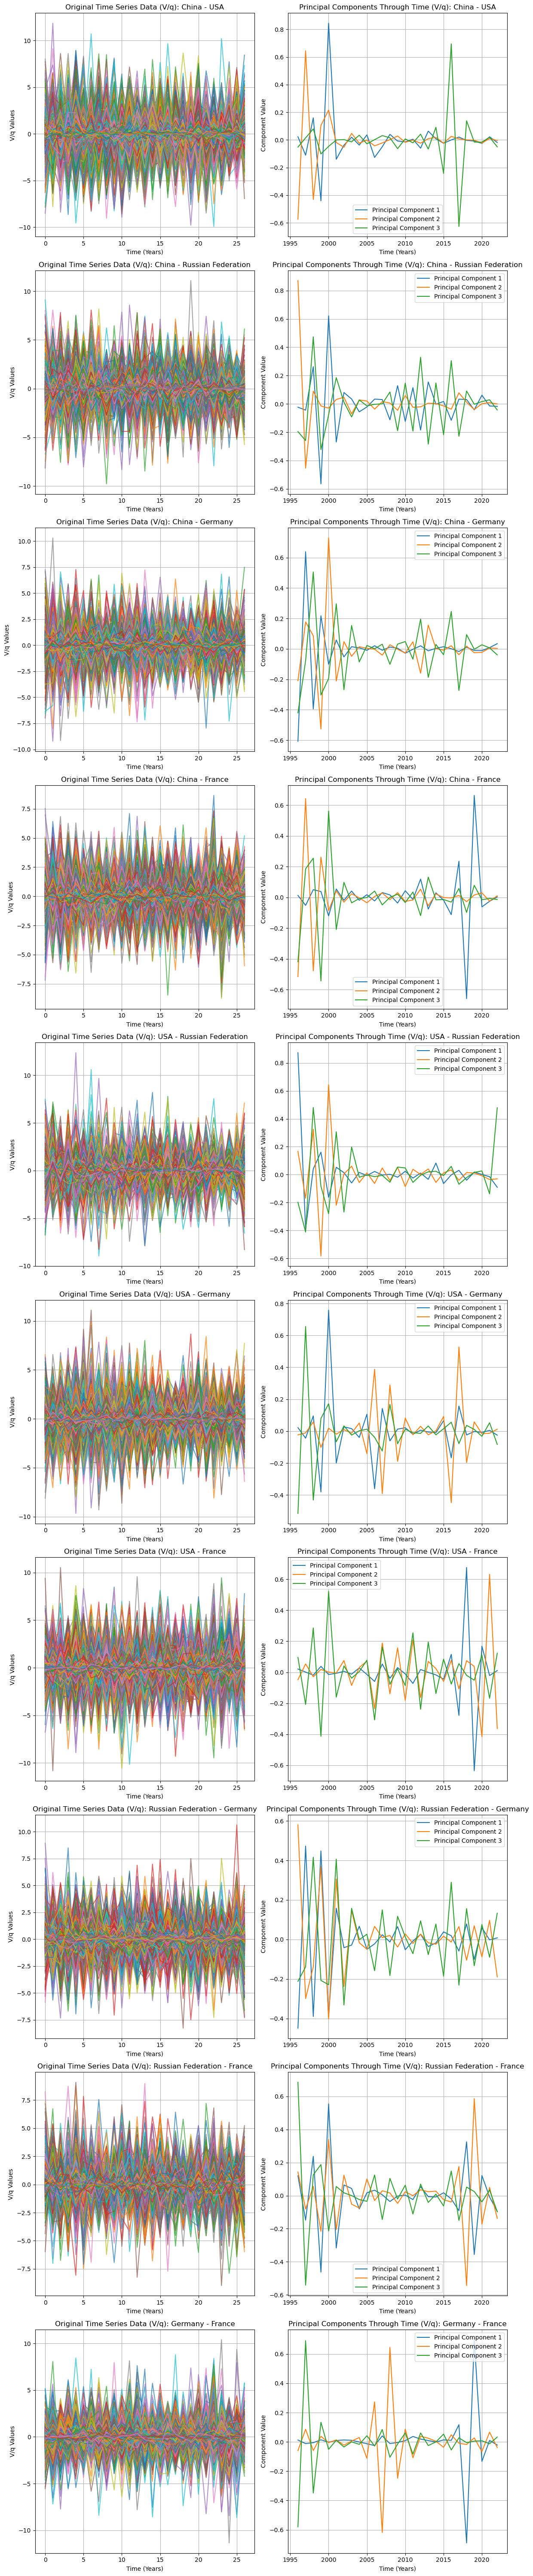

In [10]:
def process_pair(pair, pathDB, method, pbar, type):
    """
    Wrapper function to process a pair and update the progress bar.
    """
    # Create a new figure for this pair
    fig = []
    reduced_data, fig = product_outlier_detection_bilateral(pair, fig, pathDB, method, type=type)
    pbar.update(1)
    return reduced_data, fig

pathDB = os.path.join(os.getcwd(), "basedata", "total_base_data.db")
countries =['China', 'USA', 'Russian Federation', 'Germany', 'France']

unique_pairs = []

# Generate unique pairs (ignoring self-pairs and reverse pairs)
for i, country_1 in enumerate(countries):
    for j, country_2 in enumerate(countries):
        if i < j:  # Only keep upper triangle without the diagonal
            unique_pairs.append((country_1, country_2))

country_index = pd.DataFrame(unique_pairs, columns=["Country 1", "Country 2"])
method = ['PCA']
index = []
fig = []

n_jobs= 4

with tqdm(total=len(unique_pairs), desc="Processing PCAs") as pbar:
    results = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(process_pair)(pair, pathDB, method, pbar, type='v/q') for pair in unique_pairs
    )

# Filter out invalid results
valid_results = [res for res in results if res[0] is not None]

# Separate reduced_data and figs
reduced_data_list, figs = zip(*valid_results) if valid_results else ([], [])

flat_figs = [item for sublist in figs for item in sublist]

# Display the visualizations
if flat_figs:
    display_viz_array(flat_figs)


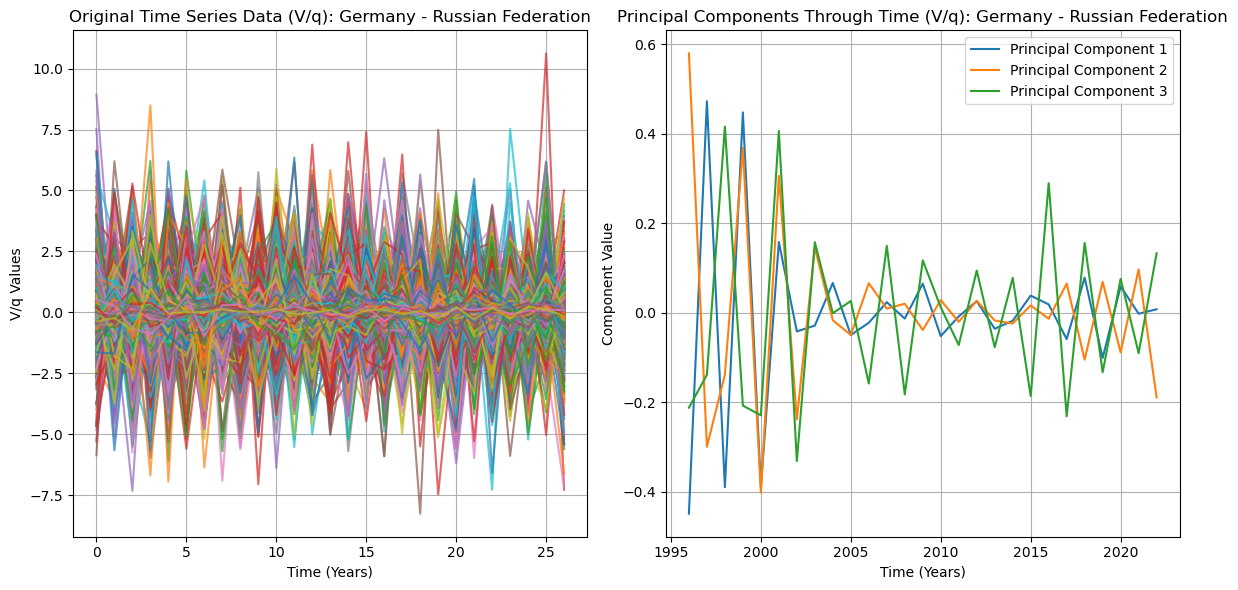

In [10]:
pair =['Germany','Russian Federation'] # 'Russia Federation', 'China', 'Germany'
pathDB = os.path.join(os.getcwd(), "basedata", "total_base_data.db")
method = ['PCA']

fig=[]

reduced_data, fig = product_outlier_detection_bilateral(pair,fig,pathDB,method,type='v/q')

display_viz_array(fig)

In [11]:
pair =['Germany','Russian Federation'] # 'Russia Federation', 'China', 'Germany'
pathDB = os.path.join(os.getcwd(), "basedata", "total_base_data.db")
method = ['PCA']
product_outlier_detection(pair,pathDB,method=method,type='v/q')

Error processing product: 'trade_direction'


Empty DataFrame
Columns: []
Index: []

In [12]:
pathDB = os.path.join(os.getcwd(), "basedata", "total_base_data.db")
FromSQLite.summarize(pathDB)

Database size: 12.71 GB

Tables in the database:
['base_data'] 

Summary for table 'base_data':
Schema:
  (0, 'year', 'INT', 0, None, 0)
  (1, 'code', 'TEXT', 0, None, 0)
  (2, 'value', 'REAL', 0, None, 0)
  (3, 'quantity', 'REAL', 0, None, 0)
  (4, 'export_country', 'TEXT', 0, None, 0)
  (5, 'import_country', 'TEXT', 0, None, 0)
Row count: 247174310

Random Sample:
   year    code     value  quantity        export_country  import_country
0  2019  621139     0.321     0.004  China, Hong Kong SAR         Finland
1  2014  640219  4135.035   202.275               Denmark     Netherlands
2  2015  071420   405.746   466.424                Brazil     Netherlands
3  2004  660191     0.580     0.075           Netherlands           Malta
4  2021  843149     4.842     0.089                Serbia  United Kingdom

First 5 Rows by Year:
   year    code   value  quantity export_country import_country
0  1995  841510  36.687     5.812    Afghanistan        Algeria
1  1995  570110  11.060     0.195   

In [13]:
pathDB = os.path.join(os.getcwd(), "basedata", "gravity.db")
FromSQLite.summarize(pathDB)

Database size: 1.01 GB

Tables in the database:
['base_data'] 

Summary for table 'base_data':
Schema:
  (0, 'year', 'INTEGER', 0, None, 0)
  (1, 'country_id_o', 'TEXT', 0, None, 0)
  (2, 'country_id_d', 'TEXT', 0, None, 0)
  (3, 'iso3_o', 'TEXT', 0, None, 0)
  (4, 'iso3_d', 'TEXT', 0, None, 0)
  (5, 'iso3num_o', 'REAL', 0, None, 0)
  (6, 'iso3num_d', 'REAL', 0, None, 0)
  (7, 'country_exists_o', 'INTEGER', 0, None, 0)
  (8, 'country_exists_d', 'INTEGER', 0, None, 0)
  (9, 'gmt_offset_2020_o', 'REAL', 0, None, 0)
  (10, 'gmt_offset_2020_d', 'REAL', 0, None, 0)
  (11, 'distw_harmonic', 'REAL', 0, None, 0)
  (12, 'distw_arithmetic', 'REAL', 0, None, 0)
  (13, 'distw_harmonic_jh', 'REAL', 0, None, 0)
  (14, 'distw_arithmetic_jh', 'REAL', 0, None, 0)
  (15, 'dist', 'REAL', 0, None, 0)
  (16, 'main_city_source_o', 'TEXT', 0, None, 0)
  (17, 'main_city_source_d', 'TEXT', 0, None, 0)
  (18, 'distcap', 'REAL', 0, None, 0)
  (19, 'contig', 'REAL', 0, None, 0)
  (20, 'diplo_disagreement', 'REAL'